# NLP Assignment #1 - Luke Schwenke

**Note:** records counts will be different, depending on when you query the API

In [1]:
import pandas as pd
import requests

In [2]:
%%time

# Define the API endpoint and parameters
url = "https://data.cityofchicago.org/resource/cwig-ma7x.json"

# Fetch the total count of records
def get_total_count(url):
    params = {
        "$select": "count(*)"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return int(data[0]['count'])

total_count = get_total_count(url)
print(f"Total number of records available: {total_count:,.0f}")

Total number of records available: 265,518
CPU times: user 19.2 ms, sys: 4.95 ms, total: 24.1 ms
Wall time: 834 ms


In [256]:
%%time

# Fetch data and load it into a pandas DataFrame
def fetch_data(url, params):
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data)

# Set the limit parameter equal to the number of available records
params = {
    "$limit": total_count
}

# Fetch the data and load it into a DataFrame
df = fetch_data(url, params)

print(f'Number of records retrieved: {df.shape[0]:,.0f}')

Number of records retrieved: 265,518
CPU times: user 5.22 s, sys: 918 ms, total: 6.14 s
Wall time: 25.5 s


In [257]:
df.head(5)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,violations
0,2587625,"TAQUERIA EL ARCO #3 EL POLLO FELIZ, INC.",EL POLLO CRIS CRIS #3,1964458,Restaurant,Risk 1 (High),7023-7025 S PULASKI RD,CHICAGO,IL,60629,...,Out of Business,41.765126421774134,-87.72227898862089,"{'type': 'Point', 'coordinates': [-87.72227898...",23,21867,63,317,15,NaN
1,2587571,ST BERNARD HOSPITAL & HEALTH CENTER,ST BERNARD HOSPITAL & HEALTH CENTER,2204276,Hospital,Risk 1 (High),326 W 64TH ST,CHICAGO,IL,60621,...,Pass,41.77821515610851,-87.63346442603714,"{'type': 'Point', 'coordinates': [-87.63346442...",53,21559,66,435,4,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ..."
2,2587633,TACOS MARIO'S LIMITED,TACOS MARIO'S LIMITED,1447643,Restaurant,Risk 1 (High),4540 W 63RD ST,CHICAGO,IL,60629,...,No Entry,41.77860614662516,-87.73659163763277,"{'type': 'Point', 'coordinates': [-87.73659163...",23,21867,63,292,15,NaN
3,2587634,TWISTED SPOKE,TWISTED SPOKE,37844,Restaurant,Risk 1 (High),501 N OGDEN AVE,CHICAGO,IL,60642,...,Fail,41.89103918038821,-87.65887051919977,"{'type': 'Point', 'coordinates': [-87.65887051...",41,22620,25,521,46,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...
4,2587597,LET'S EAT TO LIVE,LET'S EAT TO LIVE,2863029,Restaurant,Risk 1 (High),619-621 E 67th ST,CHICAGO,IL,60637,...,Pass w/ Conditions,41.77296075838975,-87.60980457245519,"{'type': 'Point', 'coordinates': [-87.60980457...",53,22260,9,348,4,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ..."


## 1. Select only the records corresponding to failed inspection (see "results" column)

In [258]:
# Examine the unique results values
list(df.results.unique())

['Out of Business',
 'Pass',
 'No Entry',
 'Fail',
 'Pass w/ Conditions',
 'Not Ready',
 'Business Not Located']

In [365]:
# Filter the results column to where the results are "Fails"
df_f = df[df.results=='Fail']
print("There are now", df_f.shape[0], "rows in the dataset after we subset to only Fail results. There were", df.shape[0], "rows.")

There are now 51801 rows in the dataset after we subset to only Fail results. There were 265518 rows.


## 2. Clean the data, making sure that there are no NaNs in "violations" column

In [267]:
df_c = df_f.dropna(subset=['violations'])
df_c = df_c.reset_index(drop=True)
print("There are now", df_c.shape[0], "rows in the dataset after removing NaN's from violations")

There are now 48381 rows in the dataset after removing NaN's from violations


## 3. "Violations" column lists the reasons for inspection failure. Those reasons are separated by "|".  Each reason consists of a regulation code, regulation description, and comments describing how the regulation was violated. 

## 4. Using regular expression, parse "violations" column to select only regulation descriptions, no code or comments

In [268]:
# Examine a subset of the violations
for i in list(range(3)):
    print("\n")
    print(df_c.violations[i])



2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CERTIFIED FOOD MANAGER WAS PRESENT WHILE TCS FOODS (BEANS AT 141F) WERE BEING PREPARED AND SERVED.  MANAGEMENT INSTRUCTED THAT A CERTIFIED FOOD MANAGER MUST BE PRESENT AT ALL TIMES WHILE TCS FOODS PREPARED AND SERVED.  PRIORITY FOUNDATION VIOLATION 7-38-012.  CITATION ISSUED. | 23. PROPER DATE MARKING AND DISPOSITION - Comments: OBSERVED EXPIRED READY-TO-EAT TCS FOODS IN THE WALK-IN COOLER (SALSA AND PORK) REFRIGERATED OVER 24 HOURS AND STORED BEYOND THE MAXIMUM 7-DAY USE-BY DATE.  MANAGEMENT INSTRUCTED TO DATE MARK ALL APPLICABLE READY-TO-EAT TCS FOODS REFRIGERATED FOR MORE THAN 24 HOURS AND DISCARD THEM OR CONSUME THEM BEFORE THE USE-BY DATE.  PRIORITY VIOLATION 7-38-005.  CITATION ISSUED. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: CLEAN THE TOP AND SIDES OF THE LOW-TEMPERATURE DISH MACHINE, THE INTERIOR AND EXTERIOR OF THE DEEP FRYERS, AND THE INTERIOR PLASTIC GUARD INSIDE OF THE ICE MACHINE. | 52. S

In [269]:
# First, remove the number and period for the code
pattern = r'\d+|\.'
df_c.violations = df_c.violations.str.replace(pattern, '', regex=True)

In [270]:
# Confirm the numbers and period are removed in the first record
df_c.violations[0]

" CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CERTIFIED FOOD MANAGER WAS PRESENT WHILE TCS FOODS (BEANS AT F) WERE BEING PREPARED AND SERVED  MANAGEMENT INSTRUCTED THAT A CERTIFIED FOOD MANAGER MUST BE PRESENT AT ALL TIMES WHILE TCS FOODS PREPARED AND SERVED  PRIORITY FOUNDATION VIOLATION --  CITATION ISSUED |  PROPER DATE MARKING AND DISPOSITION - Comments: OBSERVED EXPIRED READY-TO-EAT TCS FOODS IN THE WALK-IN COOLER (SALSA AND PORK) REFRIGERATED OVER  HOURS AND STORED BEYOND THE MAXIMUM -DAY USE-BY DATE  MANAGEMENT INSTRUCTED TO DATE MARK ALL APPLICABLE READY-TO-EAT TCS FOODS REFRIGERATED FOR MORE THAN  HOURS AND DISCARD THEM OR CONSUME THEM BEFORE THE USE-BY DATE  PRIORITY VIOLATION --  CITATION ISSUED |  NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: CLEAN THE TOP AND SIDES OF THE LOW-TEMPERATURE DISH MACHINE, THE INTERIOR AND EXTERIOR OF THE DEEP FRYERS, AND THE INTERIOR PLASTIC GUARD INSIDE OF THE ICE MACHINE |  SEWAGE & WASTE WATER PROPERLY DISPOSED - C

In [271]:
# Second, remove the comments
pattern =  r'- Comments:.*?(\||$)'

df_c.violations = df_c.violations.str.replace(pattern, '', regex=True)
df_c = df_c.reset_index(drop=True)


In [272]:
# Confirm the comments have been removed
df_c.violations[0]

' CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE   PROPER DATE MARKING AND DISPOSITION   NON-FOOD/FOOD CONTACT SURFACES CLEAN   SEWAGE & WASTE WATER PROPERLY DISPOSED   TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED   ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED   ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING   PREVIOUS CORE VIOLATION CORRECTED '

In [273]:
# Now split the string into lists of individual reasons for each row -- this is detected by 3 whitespaces
df_c['split_elements'] = df_c.violations.str.split('\s{3}', expand=False)


In [274]:
df_c.split_elements[0]

[' CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE',
 'PROPER DATE MARKING AND DISPOSITION',
 'NON-FOOD/FOOD CONTACT SURFACES CLEAN',
 'SEWAGE & WASTE WATER PROPERLY DISPOSED',
 'TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED',
 'ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED',
 'ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING',
 'PREVIOUS CORE VIOLATION CORRECTED ']

In [275]:
# Remove leading whitepsace for consistency
df_c['split_elements'] = df_c['split_elements'].apply(lambda x: [element.lstrip() for element in x])


In [276]:
# Confirm the final product
for i in list(range(3)):
    print("\n")
    print(df_c.split_elements[i])



['CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE', 'PROPER DATE MARKING AND DISPOSITION', 'NON-FOOD/FOOD CONTACT SURFACES CLEAN', 'SEWAGE & WASTE WATER PROPERLY DISPOSED', 'TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED', 'ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED', 'ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING', 'PREVIOUS CORE VIOLATION CORRECTED ']


['MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING', 'PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS', 'FOOD-CONTACT SURFACES: CLEANED & SANITIZED', 'PROPER COLD HOLDING TEMPERATURES', 'CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY', 'PERSONAL CLEANLINESS', 'FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED', 'NON-FOOD/FOOD CONTACT SURFACES CLEAN', 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN ']


['MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTI

## 5. Count how many times each regulation description occurred in the table and visualize top-10 the most frequent regulation descriptions

In [178]:
df_exploded = df_c.explode('split_elements')

# Count the occurrences of each element and sort the counts in descending order
element_counts = df_exploded['split_elements'].value_counts().sort_values(ascending=False)

# Display the counts
print(element_counts[0:10])

FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED                                     17912
FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS                                                           16017
NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS    16017
WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS                      15581
PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN                                                                                         15527
FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED                                                          14620
INSECTS, RODENTS, & ANIMALS NOT PRESENT                                                                                                 

/var/folders/rx/2jqwhb8d31960xlz0g9vlmdh0000gn/T/ipykernel_70220/2177976754.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping


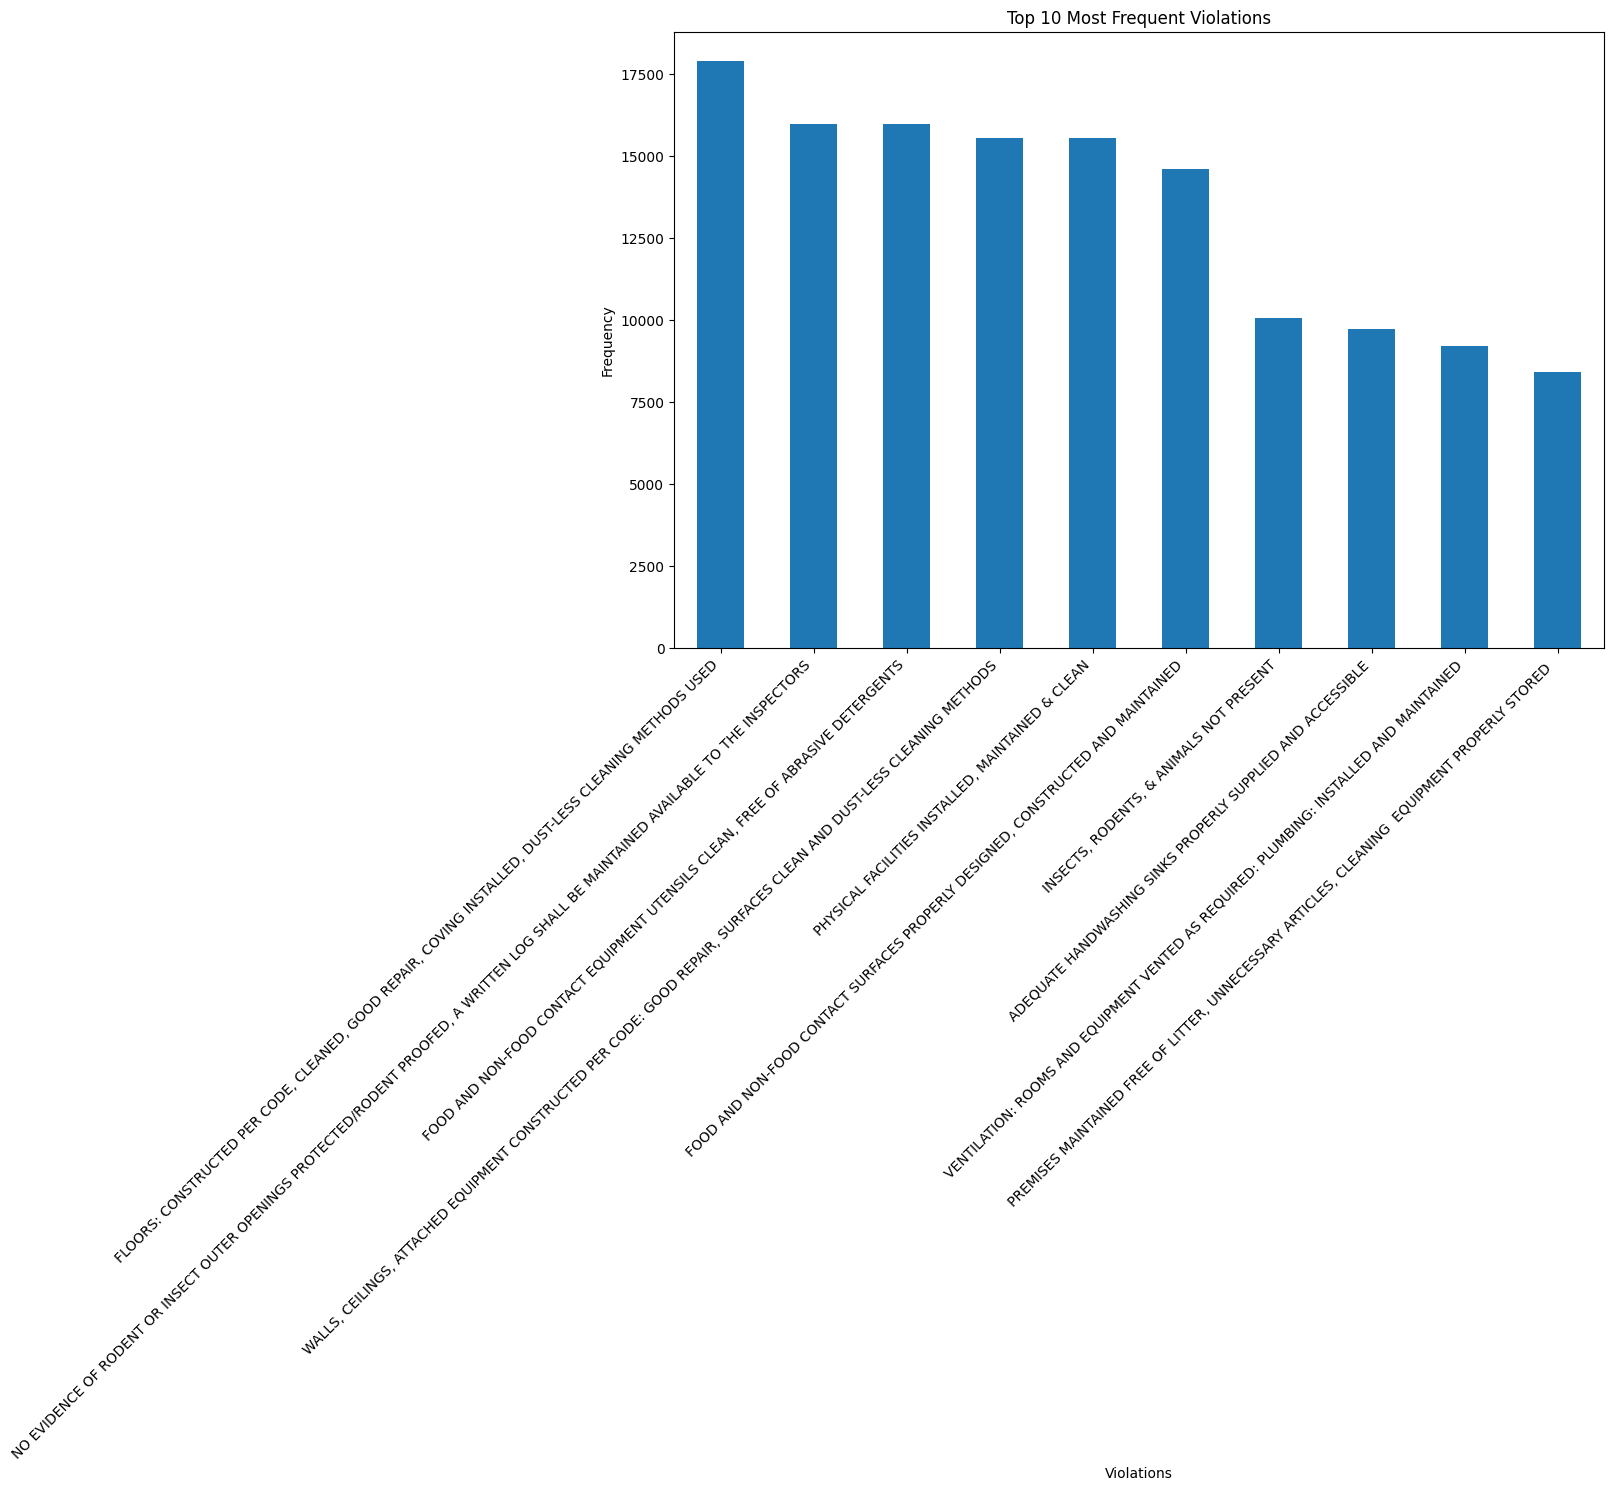

In [368]:
top_elements = element_counts.head(10)

plt.figure(figsize=(12, 8))
top_elements.plot(kind='bar')

# Set the title and labels
plt.title('Top 10 Most Frequent Violations')
plt.xlabel('Violations')
plt.ylabel('Frequency')

# Rotate the x-tick labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

## 6. Identify whether any of these restaurants are repeat offenders (explore a combination of License, Business Name, and Address variables to determine what is the best way to uniquely identify a business) and whether the violations are the same or different for these repeat offenses

In [277]:
# Rename the license column
df_exploded.rename(columns={'license_': 'license'}, inplace=True)

In [279]:
# Create a smaller dataframe of the columns we are examining
off = df_exploded[['inspection_date', 'license', 'aka_name', 'address', 'results', 'split_elements']] # split_elements is the list of violations
off = off.reset_index(drop=True)

### Solution Option #1: For each unique business (license, address, name) and violation, we will count how many occurrences that combination shows up. If this new count is greater than 1 it indicates they are repeating the same violation.

In [213]:
repeats = off.groupby(['license', 'address', 'aka_name', 'split_elements']).size().reset_index(name='count')
repeats['count'] = repeats['count'].apply(int)

In [214]:
# Filter to repeat offenders where they have the same violation occurence more than once
repeats_f = repeats[repeats['count'] > 1]

# Sort the DataFrame in descending order based on the 'count' column
repeats_f = repeats_f.sort_values(by='count', ascending=False)


#### Here are the top 10 repeat offenders who are violating with the same violation (repeating the same offense). We also list what that offense is. All of these business seem to keep violating the cleaning and maintenance of their physical facilities.

In [218]:
repeats_f.head(10)

,license,address,aka_name,split_elements,count
114526,2289197,9273 S SOUTH CHICAGO AVE,ROMA'S RESTAURANT,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",24
185021,2738649,7617 S RACINE AVE,POPEYE'S,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",23
140527,2432140,8559 S STONY ISLAND AVE,HOE TOY CHOP SUEY,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",21
166009,2583156,7723 S STATE ST,JERK TACO MAN,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",20
106774,2240254,8940-8944 S STONY ISLAND AVE,FAMILY DEN,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",20
158605,2536489,2464-2466 N LINCOLN AVE,DOG HAUS,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",20
103171,2216095,1935-1939 W 79TH ST,SMART FROM THE START,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",19
118124,2307811,2455 S KEDZIE AVE,MANOLO'S TAMALES #3,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",19
216706,60184,2829 N MILWAUKEE AVE,TAQUERIA EL RANCHITO,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",18
1414,1042888,1440 W DEVON AVE,DEVON MARKET,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",18


### Solution Option #2: For each unique business (license, address, name) we will see who has more than 1 violation (doesn't have to be the same type multiple times)

In [281]:
#repeats_2 = off.groupby(['license', 'address', 'aka_name', 'inspection_date']).size().reset_index(name='count')
repeats_2 = off.groupby(['license', 'address', 'aka_name']).size().reset_index(name='count')
repeats_2['count'] = repeats_2['count'].apply(int)

In [282]:
# Filter to repeat offenders with multiple offenses
repeats_v = repeats_2[repeats_2['count'] > 1]

# Sort the DataFrame in descending order based on the 'count' column
repeats_v = repeats_v.sort_values(by='count', ascending=False)

#### Here are the top 10 repeat offenders who have multiple violations. Note, unlike Solution #1 above they do not have to keep repeating the same offense.

In [283]:
repeats_v.head(10)

,license,address,aka_name,count
20928,60184,2829 N MILWAUKEE AVE,TAQUERIA EL RANCHITO,211
320,1095992,4770 W GRAND AVE,LAS ISLAS MARIAS,200
7790,2125165,4212 W MADISON ST,LUIGI'S PIZZA,185
3800,1893655,2446 S WESTERN AVE,MARISCOS LAS ISLITAS,179
3951,1909713,4623-4627 N BROADWAY,IYANZE,175
11958,2359305,3046-3050 W 63RD ST,LA MIXTECA POBLANA 2 LLC,172
158,1042888,1440 W DEVON AVE,DEVON MARKET,169
20274,39623,11601 S WESTERN AVE,LUMES PANCAKE HOUSE,159
11133,2308713,3714 W LAWRENCE AVE,"SU NUEVA CASA DEL GALLO BRAVO, INC.",156
20974,6231,2312 S WENTWORTH AVE,SEVEN TREASURES,156


## 7. Review the restaurants "Out of Business", is there an extended history of prior violations for these closed restaurants?

In [428]:
full = fetch_data(url, params)

In [458]:
full = full.dropna(subset=['violations'])

In [466]:
full.results.value_counts()

Pass                  103866
Fail                   48380
Pass w/ Conditions     39713
No Entry                 652
Not Ready                 76
Out of Business           43
Name: results, dtype: int64

In [494]:
# Subet to only Out of Business restaurants
oob = full[full['results'] == 'Out of Business']

In [482]:
print("There are", oob.shape[0], "out of business rows")

There are 43 out of business rows


In [490]:
def get_violations(dataset):
    data = dataset.dropna(subset=['violations'])
    data = data.reset_index(drop=True)
    #data = dataset

    pattern = r'\d+|\.'
    data.violations = data.violations.str.replace(pattern, '', regex=True)

    pattern =  r'- Comments:.*?(\||$)'
    data.violations = data.violations.str.replace(pattern, '', regex=True)
    data = data.reset_index(drop=True)

    data['split_elements'] = data.violations.str.split('\s{3}', expand=False)
    data['split_elements'] = data['split_elements'].apply(lambda x: [element.lstrip() for element in x])

    data = data.explode('split_elements')
    return data


In [495]:
oob = get_violations(oob)
print("There are", oob.shape[0], "violations total where the result = Out of Business")

There are 128 violations total where the result = Out of Business


In [496]:
history = oob.groupby(['license_', 'address', 'aka_name']).size().reset_index(name='count')
history['count'] = history['count'].apply(int)

In [501]:
# Filter to repeat offenders with multiple offenses
history_v = history[history['count'] > 1]

# Sort the DataFrame in descending order based on the 'count' column
history_v = history_v.sort_values(by='count', ascending=False)

In [503]:
history_v.head(10)

,license_,address,aka_name,count
3,1225937,1118 W FULLERTON AVE,BRANKO'S RESTAURANT,8
17,2064712,622 E 71ST ST,THE BURGER BAR,8
27,2374155,6406-6408 N OAKLEY AVE,MAWA PARADISE,7
33,2589624,5439-5441 S HALSTED ST BLDG,54 IN & OUT,6
10,1768136,1220 W TAYLOR ST,TAYLOR MADE PIZZA,6
4,12327,3407 N HALSTED ST,7-ELEVEN #25431,6
13,1843205,1 E DELAWARE PL,STARBUCKS COFFEE #13468,6
14,1844157,48 E GARFIELD BLVD,MOBIL ONE STOP CAR WASH,5
5,1242,323 E WACKER DR,PALM RESTAURANT,5
9,1767089,1102 W 35TH ST,PHIL'S PIZZA,4


## Q7 Answer: Yes, there is a history of violations for Out of Business (closed) restaurants. Above are the top 10 restaurants that are out of business and the number of violations they had before closing.

## 8. Food inspection data has 10+ years of history, do you see any changing trends in most common violations?  Plot the results for top-5 most frequent violations over time

In [357]:
# Reuse a dataset from above
df_exploded.head(3)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,violations,split_elements
0,2587634,TWISTED SPOKE,TWISTED SPOKE,37844,Restaurant,Risk 1 (High),501 N OGDEN AVE,CHICAGO,IL,60642,...,41.89103918038821,-87.65887051919977,"{'type': 'Point', 'coordinates': [-87.65887051...",41,22620,25,521,46,CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...,CITY OF CHICAGO FOOD SERVICE SANITATION CERTIF...
0,2587634,TWISTED SPOKE,TWISTED SPOKE,37844,Restaurant,Risk 1 (High),501 N OGDEN AVE,CHICAGO,IL,60642,...,41.89103918038821,-87.65887051919977,"{'type': 'Point', 'coordinates': [-87.65887051...",41,22620,25,521,46,CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...,PROPER DATE MARKING AND DISPOSITION
0,2587634,TWISTED SPOKE,TWISTED SPOKE,37844,Restaurant,Risk 1 (High),501 N OGDEN AVE,CHICAGO,IL,60642,...,41.89103918038821,-87.65887051919977,"{'type': 'Point', 'coordinates': [-87.65887051...",41,22620,25,521,46,CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...,NON-FOOD/FOOD CONTACT SURFACES CLEAN


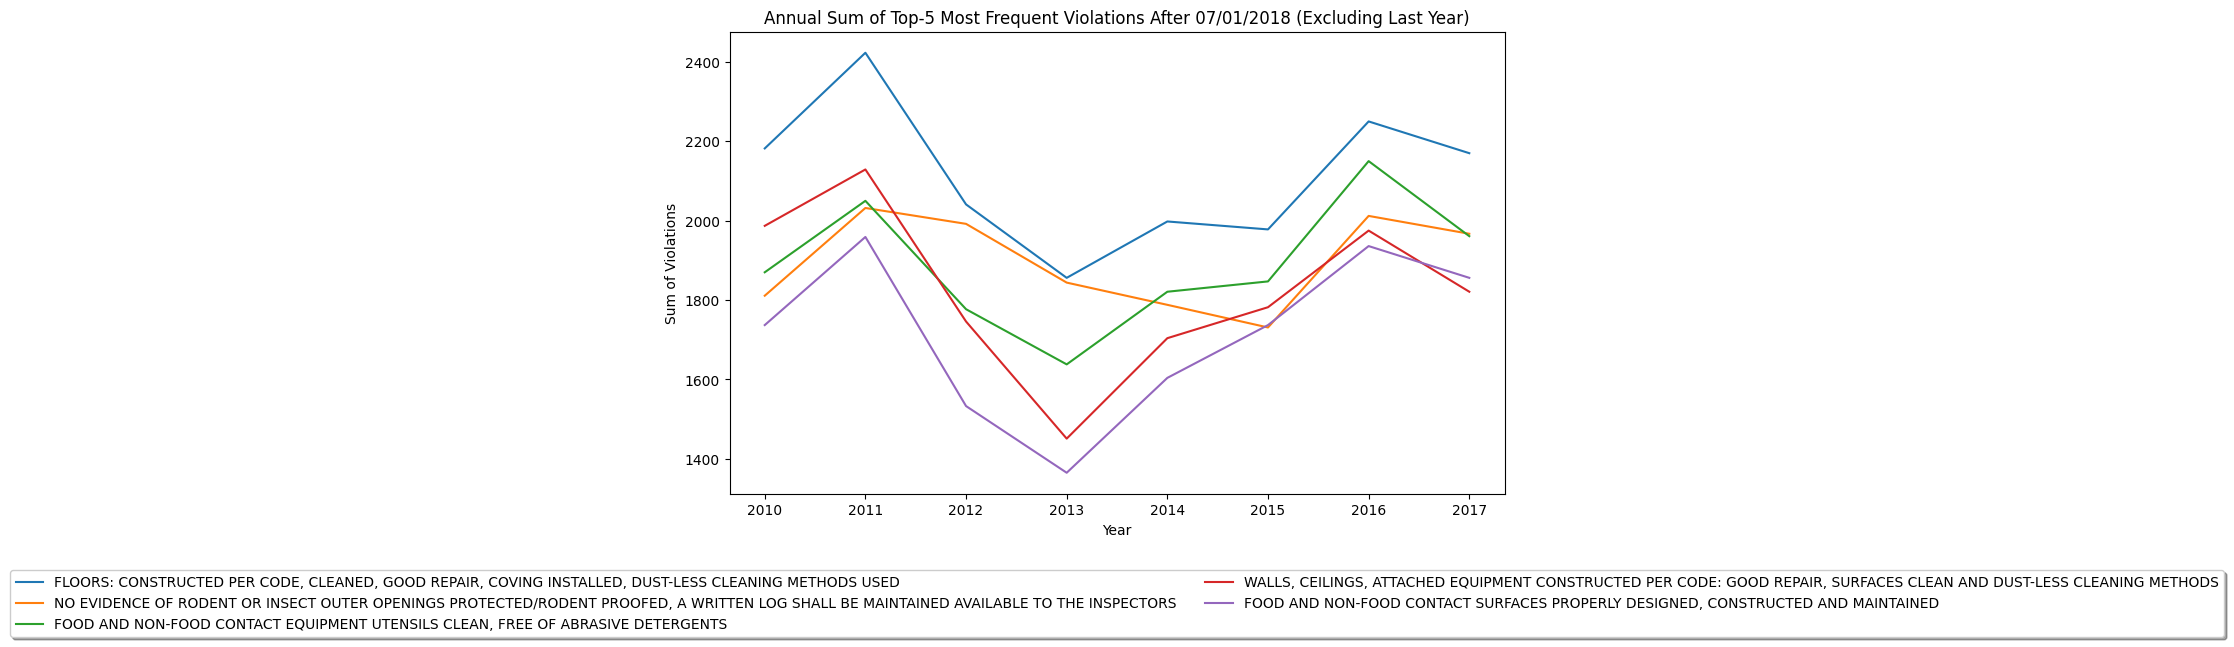

In [360]:
# Define the cutoff date
cutoff_date = pd.to_datetime('2018-07-01')

# Filter the DataFrame for violations before the cutoff date
before_cutoff = df_exploded[df_exploded['inspection_date'] < cutoff_date]

# Count each violation
violation_counts_before = before_cutoff['split_elements'].value_counts()

# Identify top-5 violations
top_violations_before = violation_counts_before.head(5).index.tolist()

# Determine the last year in your dataset
last_year = before_cutoff['inspection_date'].dt.year.max()

# Plot over time for the period before the cutoff date excluding the last year
fig, ax = plt.subplots(figsize=(10, 6))

for violation in top_violations_before:
    # Filter the DataFrame for each violation
    violation_data = before_cutoff[before_cutoff['split_elements'] == violation]
    # Exclude the last year
    violation_data = violation_data[violation_data['inspection_date'].dt.year < last_year]
    # Group by year and sum the violations
    annual_violations = violation_data.groupby(violation_data['inspection_date'].dt.year).size()
    # Plot the results
    annual_violations.plot(ax=ax, label=violation)

ax.set_title('Annual Sum of Top-5 Most Frequent Violations After 07/01/2018 (Excluding Last Year)')
ax.set_xlabel('Year')
ax.set_ylabel('Sum of Violations')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Force x-axis to show integers (years)

# Set legend at the bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.show()

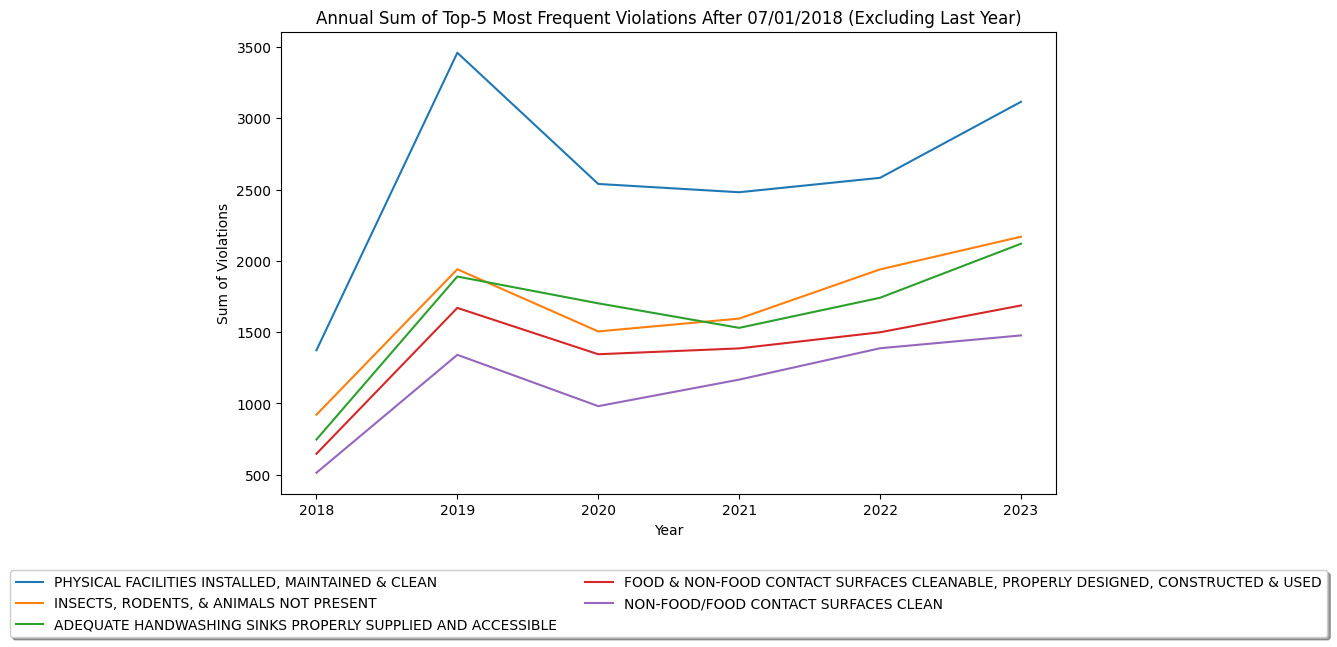

In [359]:
# Define the cutoff date
cutoff_date = pd.to_datetime('2018-07-01')

# Filter the DataFrame for violations after the cutoff date
before_cutoff = df_exploded[df_exploded['inspection_date'] > cutoff_date]

# Count each violation
violation_counts_before = before_cutoff['split_elements'].value_counts()

# Identify top-5 violations
top_violations_before = violation_counts_before.head(5).index.tolist()

# Determine the last year in your dataset
last_year = before_cutoff['inspection_date'].dt.year.max()

# Plot over time for the period before the cutoff date excluding the last year
fig, ax = plt.subplots(figsize=(10, 6))

for violation in top_violations_before:
    # Filter the DataFrame for each violation
    violation_data = before_cutoff[before_cutoff['split_elements'] == violation]
    # Exclude the last year
    violation_data = violation_data[violation_data['inspection_date'].dt.year < last_year]
    # Group by year and sum the violations
    annual_violations = violation_data.groupby(violation_data['inspection_date'].dt.year).size()
    # Plot the results
    annual_violations.plot(ax=ax, label=violation)

ax.set_title('Annual Sum of Top-5 Most Frequent Violations After 07/01/2018 (Excluding Last Year)')
ax.set_xlabel('Year')
ax.set_ylabel('Sum of Violations')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Force x-axis to show integers (years)

# Set legend at the bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.show()

## Q8 Answer: documentation indicates there was a food inspection violation change on 07/01/2018. For this reason I have broken the data out into 2 plots to show the trend in top 5 violations over time. Plot #1 indicates a downward trend as time approaches 2018 but then an increase afterwards. Plot #2 indicates an increase in violations around 2019 but then a drop around COVID 2020-2022 before increasing again closer to 2023.

#### Documentation Reference: https://web.archive.org/web/20190907034257/http://dev.cityofchicago.org/open%20data/data%20portal/2018/06/29/food-violations-changes.html 